Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Pastas com 'face' em MyDrive:
 - /content/drive/MyDrive/my drive face
Imagens encontradas: 5
OK! 5 imagens processadas em: /content/drive/MyDrive/my drive face/processed


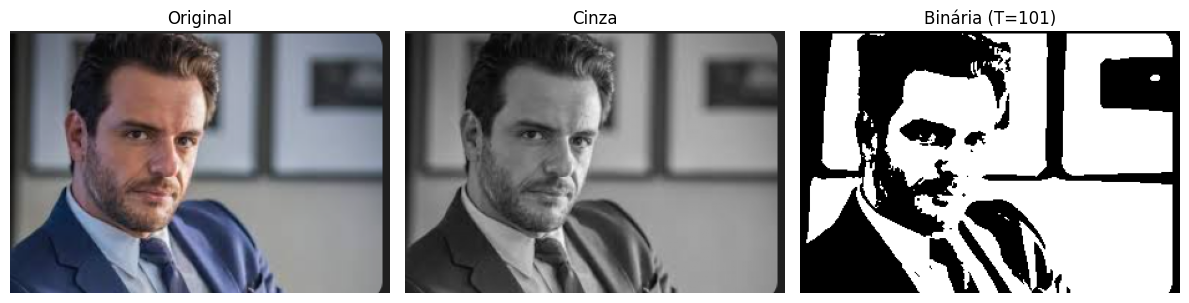

In [4]:
# Monte o Drive (se ainda não estiver montado)
from google.colab import drive
drive.mount('/content/drive')

from pathlib import Path
import numpy as np, matplotlib.pyplot as plt
from PIL import Image

# --------- AJUSTE EXATO DO CAMINHO DA PASTA ---------
PASTA = Path('/content/drive/MyDrive/my drive face')  # <-- com espaço

# Checagem: liste pastas que contêm "face"
print("Pastas com 'face' em MyDrive:")
for p in Path('/content/drive/MyDrive').iterdir():
    if p.is_dir() and 'face' in p.name.lower():
        print(" -", p)

# --------- funções ---------
def to_grayscale(pil_img: Image.Image) -> np.ndarray:
    arr = np.asarray(pil_img.convert("RGB"), dtype=np.float32)
    r,g,b = arr[...,0], arr[...,1], arr[...,2]
    gray = 0.299*r + 0.587*g + 0.114*b
    return gray.clip(0,255).astype(np.uint8)

def otsu_threshold(gray: np.ndarray) -> int:
    hist,_ = np.histogram(gray.ravel(), bins=256, range=(0,256))
    p = hist / (hist.sum() + 1e-12)
    w = np.cumsum(p)
    m = np.cumsum(p*np.arange(256))
    mT = m[-1]
    var_b = (mT*w - m)**2 / (w*(1-w) + 1e-12)
    return int(np.argmax(var_b))

def binarize(gray: np.ndarray, T=None):
    if T is None: T = otsu_threshold(gray)
    return (gray >= T).astype(np.uint8)*255, T

# --------- coletar imagens (inclui .png/.jpg/.jpeg em subpastas) ---------
exts = {'.jpg','.jpeg','.png'}
imgs = [p for p in PASTA.rglob('*') if p.suffix.lower() in exts]

print(f"Imagens encontradas: {len(imgs)}")
assert imgs, f"Nenhuma imagem {exts} encontrada em {PASTA} (verifique o nome da pasta e a extensão)."

# --------- processar todas e salvar em /processed ---------
out_dir = PASTA/'processed'
out_dir.mkdir(exist_ok=True)

for p in imgs:
    img = Image.open(p)
    gray = to_grayscale(img)
    bin_img, T = binarize(gray)
    base = p.stem
    Image.fromarray(gray).save(out_dir/f'{base}_cinza.png')
    Image.fromarray(bin_img).save(out_dir/f'{base}_binaria_T{T}.png')

print(f"OK! {len(imgs)} imagens processadas em:", out_dir)

# Preview do primeiro resultado
first = imgs[0]
orig = Image.open(first)
gray = to_grayscale(orig)
bin_, T = binarize(gray)
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(orig); plt.title('Original'); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(gray, cmap='gray', vmin=0, vmax=255); plt.title('Cinza'); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(bin_, cmap='gray', vmin=0, vmax=255); plt.title(f'Binária (T={T})'); plt.axis('off')
plt.tight_layout(); plt.show()
